# old version code

## Base

In [1]:
import json
import os
import numpy as np
import datetime
import cv2
import random
import re
import multiprocessing

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" # so the IDs match nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # "0, 1" for multiple

In [2]:
from tensorflow.python.ops import math_ops
from tensorflow.python.keras._impl.keras import backend as K

/home/xy/.pyenv/versions/anaconda3-5.1.0/envs/tf16/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/xy/.pyenv/versions/anaconda3-5.1.0/envs/tf16/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/xy/.pyenv/versions/anaconda3-5.1.0/envs/tf16/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/xy/.pyenv/versions/anaconda3-5.1.0/envs/tf16/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
import tensorflow as tf

In [4]:
# adam, momentum or nesterov
opt_string = "momentum"

LEARNING_RATE = 0.001
#using in lr decay
LR_DECAY = 0.95
#using in momentum and nesterov
MOMENTUM = 0.9
#using in adam
ADAM_BETA_1 = 0.9
ADAM_BETA_2 = 0.99

WEIGHT_DECAY = 0.01

#base hyper-parameter
INPUT_SHAPE = (1024,512,3)
MEAN_PIXEL = np.array([93.2,104.6,116.6])
BATCH_SIZE = 20
VALIDATION_STEPS = 30
CLASS_NUMS = 4
IS_SAVE = False

In [5]:
im_dir = '../dataset/bodytype/split/'
train_json = '../dataset/bodytype/women_v4_train.json'
val_json = '../dataset/bodytype/women_v4_val.json'
base_dir = './logs'

In [6]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
tf.keras.backend.set_session(session)

In [7]:
def build_model(image_shape):
    resnet_model = tf.keras.applications.resnet50.ResNet50(include_top=False,
                                weights='imagenet',input_shape=image_shape,pooling='avg')
    resnet_output = resnet_model.output

    resnet_input = resnet_model.input

    #fla_fm = tf.keras.layers.Flatten()(resnet_output)

    output = tf.keras.layers.Dense(CLASS_NUMS,activation='softmax',name='fc_softmax')(resnet_output)

    sm_model = tf.keras.models.Model(inputs = resnet_input,outputs = output, name = 'res50_softmax')
    
    return sm_model

In [8]:
def set_trainable(pattern, keras_model=None, verbose=1):
    """Sets model layers as trainable if their names match
    the given regular expression.
    """
    print("\nIn:",keras_model.name)
    print("The trainable layers:")
    # In multi-GPU training, we wrap the model. Get layers
    # of the inner model because they have the weights.
    layers = keras_model.layers
    for layer in layers:
        # Is the layer a model?
        if layer.__class__.__name__ == 'Model':
            set_trainable(
                pattern, keras_model=layer)
            continue

        if not layer.weights:
            continue
        # Is it trainable?
        trainable = bool(re.fullmatch(pattern, layer.name))
        # Update layer. If layer is a container, update inner layer.
        layer.trainable = trainable
        # Print trainble layer names
        if trainable and verbose > 0:
            print(" ",layer.name)

In [9]:
def imread(path):
    im = cv2.imread(path)
    if im is None:
        return None
    
    im = im/255
    
    im_pad = np.zeros(INPUT_SHAPE,dtype=np.float64)
    h,w = im.shape[:2]
    if h/w > INPUT_SHAPE[0]/INPUT_SHAPE[1]:
        re_h = INPUT_SHAPE[0]
        re_w = int(w * (re_h / h))
    else:
        re_w = INPUT_SHAPE[1]
        re_h = int(h * (re_w / w))
    re_im = cv2.resize(im,(re_w,re_h))
    im_pad[:re_h,:re_w,:] = re_im.copy()
    return im_pad

In [10]:
class mysequence(tf.keras.utils.Sequence):
    def __init__(self, im_dir, json_path, batch_size,class_weights=[0.2,0.5,1,0.8]):
        self.batch_size = batch_size
        self.class_weights = class_weights
        self.im_dir = im_dir
        f = open(json_path,'r')
        self.info = json.load(f)
        self.names = list(self.info.keys())
        self.offset = 0
        random.shuffle(self.names)
        f.close()
        self.test = {}
    
    def __len__(self):
        return int(len(self.names) / self.batch_size) # the length is the number of batches
    
    def on_epoch_end(self):
        self.offset = 0
        random.shuffle(self.names)
    
    def __getitem__(self, batch_id):
        images = []
        labels = []
        for i in range(batch_id * self.batch_size, (batch_id+1) * self.batch_size):
            names_num = len(self.names)
            while True:
                index = int((i+self.offset) % names_num)
                name = self.names[index]
                path = os.path.join(self.im_dir, name)
                               
#                 im = imread(path)
#                 if im is None:
#                     self.offset += 1
#                     continue
                label = self.info[name]['label']
                if random.random() > self.class_weights[label]:
                    self.offset += 1
                    continue
#                 images.append(im)
                
                if index not in self.test.keys():
                    self.test[index] = 0
                self.test[index] += 1
                
                labels.append(label)
                break
#         images = np.array(images)
        labels = np.array(labels)
#         labels = (np.arange(CLASS_NUMS) == labels[:, None]).astype(np.float32)
#         labels = tf.keras.utils.to_categorical(labels,num_classes = CLASS_NUMS)
        return images, labels

In [10]:
def generator(im_dir, json_path, batch_size):
    #the generator will full all cpu who can use, and stop the process

    index = 0
    f = open(json_path, 'r')
    info = json.load(f)
    f.close()
    names = list(info.keys())
    random.shuffle(names)
    i = 0
    while True:
        try:
            if i == 0:
                images = []
                labels = []
            name = names[index]
            path = os.path.join(im_dir, name)
            im = imread(path)
            if im is None:
                continue

            label = info[name]['label']

            images.append(im)
            labels.append(label)
            i += 1
            index += 1
            if index == len(names):
                index = 0
                random.shuffle(names)
            if i >= batch_size:
                images = np.array(images)
                labels = np.array(labels)
                labels = tf.keras.utils.to_categorical(labels,num_classes = CLASS_NUMS)
                yield (images, labels)
                i = 0
        except Exception as e:
            print(e)
            raise

In [11]:
class mysequence(tf.keras.utils.Sequence):
    def __init__(self, im_dir, json_path, batch_size):
        self.batch_size = batch_size
        self.im_dir = im_dir
        f = open(json_path,'r')
        self.info = json.load(f)
        self.names = list(self.info.keys())
        random.shuffle(self.names)
#         self.index = 0
        f.close()
    
    def __len__(self):
        return int(len(self.names) / self.batch_size) # the length is the number of batches
    
    def on_epoch_end(self):
        random.shuffle(self.names)
    
    def __getitem__(self, batch_id):
        images = []
        labels = []
        names = []
        for i in range(batch_id * self.batch_size, (batch_id+1) * self.batch_size):
            names_num = len(self.names)
            index = int(i % names_num)
            name = self.names[index]
            path = os.path.join(self.im_dir, name)
            im = imread(path)
            if im is None:
                continue
            
            label = self.info[name]['label']
            
            images.append(im)
            labels.append(label)
        images = np.array(images)
        labels = np.array(labels)
        #labels = (np.arange(CLASS_NUMS) == labels[:, None]).astype(np.float32)
        labels = tf.keras.utils.to_categorical(labels,num_classes = CLASS_NUMS)
        return images, labels

#     def __getitem__(self, batch_id):
#         outputs = []
#         for i in range(batch_id * self.batch_size, (batch_id+1) * self.batch_size):
#             names_num = len(self.names)
#             index = int(i % names_num)
#             name = self.names[index]
#             path = os.path.join(self.im_dir, name)
#             im = imread(path)
#             if im is None:
#                 continue
            
#             label = self.info[name]['label']
            
#             output = {'im':im,'label':label,'name':name}
#             outputs.append(output)
#         return outputs

In [12]:
class LRTensorBoard(tf.keras.callbacks.TensorBoard):

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def on_epoch_end(self, epoch, logs=None):
        logs.update({'lr': tf.keras.backend.eval(self.model.optimizer.lr)})
        super().on_epoch_end(epoch, logs)

In [13]:
def lrdecay(epoch):
    lr_new = LEARNING_RATE * LR_DECAY ** epoch
    return lr_new

In [14]:
def batchEnd(batch,logs):
    print("\nfinished batch " + str(batch) + ": " + str(logs) + "\n")

In [15]:
def ca(y_true, y_pred):
    return math_ops.cast(
      math_ops.equal(
          math_ops.argmax(y_true, axis=-1), math_ops.argmax(y_pred, axis=-1)),
      K.floatx())

## function test

In [27]:
import matplotlib.pyplot as plt

In [28]:
ge = mysequence(im_dir=im_dir,json_path=sample_json,batch_size=10)

In [29]:
ge_it = iter(ge)

In [30]:
im,la,na = next(ge_it)

17000-17023-1.jpg [0. 0. 1. 0.]


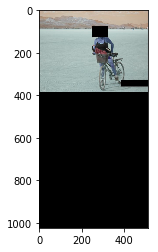

10000-10443-2.jpg [0. 0. 0. 1.]


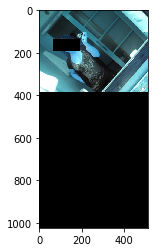

4000-4305-4.jpg [0. 0. 1. 0.]


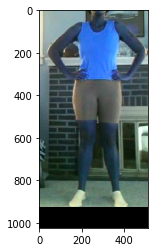

18000-18804-2.jpg [0. 1. 0. 0.]


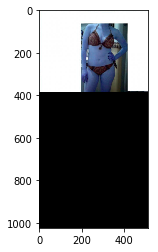

36000-36590-1.jpg [0. 1. 0. 0.]


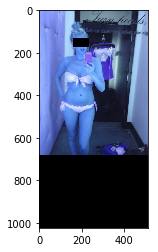

21000-21096-12.jpg [0. 0. 0. 1.]


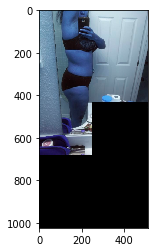

19000-19938-5.jpg [0. 0. 0. 1.]


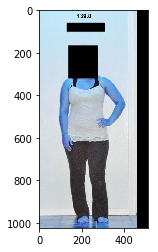

29000-29438-1.jpg [0. 0. 1. 0.]


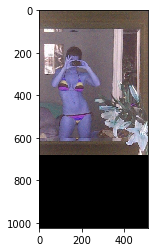

28000-28151-2.jpg [0. 0. 1. 0.]


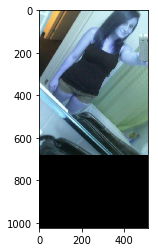

33000-33753-5.jpg [0. 0. 0. 1.]


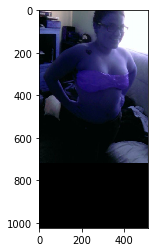

In [32]:
for i in range(10):
    print(na[i],la[i])
    plt.figure(i)
    plt.imshow(im[i])
    plt.show()

In [17]:
model = build_model((None,None,3))

In [22]:
for w in model.trainable_weights:
    tf.add_to_collection(tf.GraphKeys.WEIGHTS,w)

In [23]:
tf.get_collection(tf.GraphKeys.WEIGHTS)

[<tf.Variable 'conv1/kernel:0' shape=(7, 7, 3, 64) dtype=float32_ref>,
 <tf.Variable 'conv1/bias:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'bn_conv1/gamma:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'bn_conv1/beta:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'res2a_branch2a/kernel:0' shape=(1, 1, 64, 64) dtype=float32_ref>,
 <tf.Variable 'res2a_branch2a/bias:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'bn2a_branch2a/gamma:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'bn2a_branch2a/beta:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'res2a_branch2b/kernel:0' shape=(3, 3, 64, 64) dtype=float32_ref>,
 <tf.Variable 'res2a_branch2b/bias:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'bn2a_branch2b/gamma:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'bn2a_branch2b/beta:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'res2a_branch2c/kernel:0' shape=(1, 1, 64, 256) dtype=float32_ref>,
 <tf.Variable 'res2a_branch2c/bias:0' shape=(256,) dtype=float32_ref>,
 <tf.V

In [24]:
regularizer = tf.contrib.layers.l2_regularizer(scale=0.001)
reg_term = tf.contrib.layers.apply_regularization(regularizer)

loss = (tf.reduce_mean(
tf.nn.sigmoid_cross_entropy_with_logits(labels=y_,

logits=z_3)) + reg_term)

In [18]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, None, None, 3) 0                                            
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, None, None, 64 9472        input_1[0][0]                    
____________________________________________________________________________________________________
bn_conv1 (BatchNormalization)    (None, None, None, 64 256         conv1[0][0]                      
____________________________________________________________________________________________________
activation_1 (Activation)        (None, None, None, 64 0           bn_conv1[0][0]                   
___________________________________________________________________________________________

## train

In [16]:
layer_dict = {
            # all layers but the backbone
            "heads": r"(fc.*)",
            # From a specific Resnet stage and up
            "3+": r"(res3.*)|(bn3.*)|(res4.*)|(bn4.*)|(res5.*)|(bn5.*)|(fc.*)",
            "4+": r"(res4.*)|(bn4.*)|(res5.*)|(bn5.*)|(fc.*)",
            "5+": r"(res5.*)|(bn5.*)|(fc.*)",
            # All layers
            "all": ".*",
        }

In [30]:
model = build_model()
train_layer = layer_dict['4+']
set_trainable(train_layer,model)
if opt_string == "momentum":
    opt = tf.keras.optimizers.SGD(lr=LEARNING_RATE,momentum=MOMENTUM)
if opt_string == "nesterov":
    opt = tf.keras.optimizers.SGD(lr=LEARNING_RATE,momentum=MOMENTUM,nesterov=True)
if opt_string == "adam":
    opt = tf.keras.optimizers.Adam(lr=LEARNING_RATE,beta_1=ADAM_BETA_1,beta_2=ADAM_BETA_2)
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])
# model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=[ca])
#model.compile(optimizer=opt,loss='sparse_categorical_crossentropy',metrics=['sparse_categorical_accuracy'])

# train_generator = generator(im_dir,train_json,BATCH_SIZE)
# train_generator = mysequence(im_dir, train_json, BATCH_SIZE)
train_generator = mysequence(im_dir, sample_json, BATCH_SIZE)
# train_generator = generator(im_dir, sample_json, BATCH_SIZE)
# val_generator = generator(im_dir,val_json,BATCH_SIZE)
# val_generator = mysequence(im_dir, val_json, BATCH_SIZE)
val_generator = mysequence(im_dir, sample_json, BATCH_SIZE)
# val_generator = generator(im_dir, sample_json, BATCH_SIZE)


In: res50_softmax
The trainable layers:
  res4a_branch2a
  bn4a_branch2a
  res4a_branch2b
  bn4a_branch2b
  res4a_branch2c
  res4a_branch1
  bn4a_branch2c
  bn4a_branch1
  res4b_branch2a
  bn4b_branch2a
  res4b_branch2b
  bn4b_branch2b
  res4b_branch2c
  bn4b_branch2c
  res4c_branch2a
  bn4c_branch2a
  res4c_branch2b
  bn4c_branch2b
  res4c_branch2c
  bn4c_branch2c
  res4d_branch2a
  bn4d_branch2a
  res4d_branch2b
  bn4d_branch2b
  res4d_branch2c
  bn4d_branch2c
  res4e_branch2a
  bn4e_branch2a
  res4e_branch2b
  bn4e_branch2b
  res4e_branch2c
  bn4e_branch2c
  res4f_branch2a
  bn4f_branch2a
  res4f_branch2b
  bn4f_branch2b
  res4f_branch2c
  bn4f_branch2c
  res5a_branch2a
  bn5a_branch2a
  res5a_branch2b
  bn5a_branch2b
  res5a_branch2c
  res5a_branch1
  bn5a_branch2c
  bn5a_branch1
  res5b_branch2a
  bn5b_branch2a
  res5b_branch2b
  bn5b_branch2b
  res5b_branch2c
  bn5b_branch2c
  res5c_branch2a
  bn5c_branch2a
  res5c_branch2b
  bn5c_branch2b
  res5c_branch2c
  bn5c_branch2c
  fc_s

In [31]:
now = datetime.datetime.now()

base_name = 'res50_softmax_' + opt_string
log_dir = os.path.join(base_dir, base_name+"_{:%Y%m%dT%H%M}".format(now))
checkpoint_path = os.path.join(log_dir, base_name+"_*epoch*.h5")
checkpoint_path = checkpoint_path.replace("*epoch*", "{epoch:04d}")

In [33]:
if IS_SAVE:
    callbacks = [
            LRTensorBoard(log_dir=log_dir,
                    histogram_freq=0, write_graph=True, write_images=False),
            # tf.keras.callbacks.TensorBoard(log_dir=log_dir,
            #          histogram_freq=0, write_graph=True, write_images=False),
            tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                    verbose=0, save_weights_only=True),
            tf.keras.callbacks.LearningRateScheduler(lrdecay),
        ]
else:
    callbacks = [
            tf.keras.callbacks.LambdaCallback(on_batch_end=batchEnd,on_epoch_end=batchEnd),
            tf.keras.callbacks.LearningRateScheduler(lrdecay),
        ]

In [ ]:
model.fit_generator(train_generator,
                   steps_per_epoch = 1,
                   epochs = 200,
                   validation_data=val_generator,
                   validation_steps=1,
                   callbacks=callbacks,
                   workers = multiprocessing.cpu_count(),
#                    workers = 1,
                   max_queue_size = 10,
                   shuffle = True,
                   use_multiprocessing = True)

Epoch 1/200


Process ForkPoolWorker-55:
Process ForkPoolWorker-59:
Process ForkPoolWorker-61:
Process ForkPoolWorker-54:
Process ForkPoolWorker-56:
Process ForkPoolWorker-62:
Process ForkPoolWorker-58:
Process ForkPoolWorker-60:
Process ForkPoolWorker-57:
Process ForkPoolWorker-63:
Process ForkPoolWorker-53:
Process ForkPoolWorker-52:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/xy/.pyenv/versions/anaconda3-5.1.0/envs/tf14/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/xy/.pyenv/versions/anaconda3-5.1.0/envs/tf14/lib/python3.5/multiprocessing/process.py", line 252, in 

KeyboardInterrupt
  File "/home/xy/.pyenv/versions/anaconda3-5.1.0/envs/tf14/lib/python3.5/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
KeyboardInterrupt
  File "/home/xy/.pyenv/versions/anaconda3-5.1.0/envs/tf14/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
KeyboardInterrupt
KeyboardInterrupt
  File "/home/xy/.pyenv/versions/anaconda3-5.1.0/envs/tf14/lib/python3.5/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/home/xy/.pyenv/versions/anaconda3-5.1.0/envs/tf14/lib/python3.5/multiprocessing/pool.py", line 108, in worker
    task = get()
KeyboardInterrupt
  File "/home/xy/.pyenv/versions/anaconda3-5.1.0/envs/tf14/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/home/xy/.pyenv/versions/anaconda3-5.1.0/envs/tf14/lib/python3.5/multiprocessing/connection.py", line 216, in recv_bytes
    

In [ ]:
im_dir = './dataset/image_women/'
json_path = './dataset/women_sample_label.json'
f = open(json_path,'r')
info = json.load(f)
f.close()
names = list(info.keys())
images = []
labels = []
for name in names:
    path = os.path.join(im_dir, name)
    im = imread(path)
    if im is None:
        continue
            
    label = info[name]['label']
            
    images.append(im)
    labels.append(label)            
images = np.array(images)
labels = np.array(labels)
#labels = (np.arange(CLASS_NUMS) == labels[:, None]).astype(np.float32)
labels = tf.keras.utils.to_categorical(labels,num_classes = CLASS_NUMS)

In [ ]:
model.fit(x=images,y=labels,batch_size=20,epochs=10,callbacks=callbacks,steps_per_epoch=10)

## Inference

In [16]:
import matplotlib.pyplot as plt

In [17]:
model_path = './logs/res50_softmax_momentum_20180722T0055/res50_softmax_momentum_0047.h5'

In [18]:
model = build_model()
model.load_weights(model_path)

[[6.2731530e-08 4.1006213e-05 2.3297983e-04 9.9972588e-01]]
{'bmi': '31.39', 'label': 3}
[3]
[[0. 0. 0. 1.]]


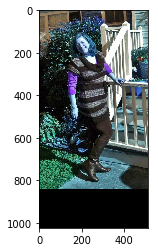

In [20]:
im_dir = './dataset/image_women/'

f = open('./dataset/women_val_label.json','r')
info = json.load(f)
f.close()

names = list(info.keys())
name = names[3]

path = os.path.join(im_dir,name)
im = imread(path)
im = np.array([im])
result = model.predict(im)
print(result)
result_ = np.argmax(result,axis=-1)

print(info[name])
print(result_)

labels = np.array([info[name]['label']])

la = tf.keras.utils.to_categorical(labels,num_classes = 4)
print(la)

plt.imshow(im[0])
plt.show()

In [23]:
right = 0
error = 0
f = open('./dataset/women_train_label.json','r')
info = json.load(f)
f.close()

names = list(info.keys())
for i,name in enumerate(names):
    path = os.path.join(im_dir,name)
    im = imread(path)
    if im is None:
        continue
    im = np.array([im])
    result = model.predict(im)
    result = np.argmax(result)
    
    if info[name]['label'] == result:
        right += 1
    else:
        error += 1
    print(i,'/',len(names),end='\r')

In [24]:
print(right/(right+error))

0.9997876106194691


## Resnet Test

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" # so the IDs match nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"] = "" # "0, 1" for multiple
from resnet import resnet_graph
import keras

/home/xy/.pyenv/versions/anaconda3-5.1.0/envs/tf14/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
image_input = keras.Input((None,None,3))

In [3]:
_,_,_,_,C5 = resnet_graph(image_input,"resnet101")

In [4]:
flatten = keras.layers.GlobalAveragePooling2D()(C5)

In [5]:
output = keras.layers.Dense(4,activation='softmax',name='fc_softmax')(flatten)

In [6]:
model = keras.models.Model(image_input,output)

In [7]:
model.load_weights('./mask_rcnn_coco.h5',by_name=True)

In [10]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        input_1[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNorm)            (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 6 0           bn_conv1[0][0]                   
__________________________________________________________________________________________________
max_poolin

# new code test

In [1]:
import tensorflow as tf

In [2]:
from model import Model

In [3]:
model = Model()

============> train from all


In [4]:
for w in model.model.trainable_weights:
    if 'kernel' in w.name:
        print(w)

<tf.Variable 'block1_conv1/kernel:0' shape=(3, 3, 3, 64) dtype=float32_ref>
<tf.Variable 'block1_conv2/kernel:0' shape=(3, 3, 64, 64) dtype=float32_ref>
<tf.Variable 'block2_conv1/kernel:0' shape=(3, 3, 64, 128) dtype=float32_ref>
<tf.Variable 'block2_conv2/kernel:0' shape=(3, 3, 128, 128) dtype=float32_ref>
<tf.Variable 'block3_conv1/kernel:0' shape=(3, 3, 128, 256) dtype=float32_ref>
<tf.Variable 'block3_conv2/kernel:0' shape=(3, 3, 256, 256) dtype=float32_ref>
<tf.Variable 'block3_conv3/kernel:0' shape=(3, 3, 256, 256) dtype=float32_ref>
<tf.Variable 'block4_conv1/kernel:0' shape=(3, 3, 256, 512) dtype=float32_ref>
<tf.Variable 'block4_conv2/kernel:0' shape=(3, 3, 512, 512) dtype=float32_ref>
<tf.Variable 'block4_conv3/kernel:0' shape=(3, 3, 512, 512) dtype=float32_ref>
<tf.Variable 'block5_conv1/kernel:0' shape=(3, 3, 512, 512) dtype=float32_ref>
<tf.Variable 'block5_conv2/kernel:0' shape=(3, 3, 512, 512) dtype=float32_ref>
<tf.Variable 'block5_conv3/kernel:0' shape=(3, 3, 512, 512